In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

# Some more imports  

In [2]:
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.aqua.algorithms import QPE
from qiskit.circuit.library import QFT
from qiskit.quantum_info import random_statevector
from qiskit.opflow import (StateFn, Zero, One, Plus, Minus, H,
                           DictStateFn, VectorStateFn, CircuitStateFn, OperatorStateFn)
from qiskit.opflow import I, X, Z, Y, CX
from scipy import linalg 
pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


# Defining matrix to transpile convertor, time evolution convertor(if time evolution is not already defined in the matrix, just remove the comments of evoloperator()) and my_qpe that takes in arguments and also applies inverse QFT.

In [3]:
#Operator to (1) transpile convertor
def qc(operator,qubit_list):
    qc = QuantumCircuit(len(qubit_list))
    qc.unitary(operator,qubit_list)
    qc = transpile(qc)
    return qc 

In [6]:
# my_qpe takes in work qubits, simulation qubits, initialization condition and number of repetitions gate and applies QFT inverse
def my_qpe(w_qubits,s_qubits, gate,n, initialize = None, repetitions=1):  
    qpe_0 = QuantumCircuit(w_qubits+s_qubits,w_qubits)
    if (initialize == 'x') :
        for i in range(s_qubits):
            qpe_0.x(i+w_qubits)
    elif (initialize == 'r'):
        initial_state = {}
        for i in range(s_qubits):
            initial_state[i] = qpe_0.initialize(random_statevector(2).data, i+w_qubits)
    elif (initialize == 'h'):
        for i in range(s_qubits):
            qpe_0.h(i+w_qubits)
    elif (initialize == 'cx'):
        e,v = np.linalg.eig(U2_op)
        v = np.transpose(v)
        qpe_0.initialize(v[1], [w_qubits+0, w_qubits+1])
    elif (initialize == 'deut'):
        e,v = np.linalg.eig(U2_op)
        v = np.transpose(v)
        qpe_0.initialize(v[3], [w_qubits+0, w_qubits+1])
    elif (initialize == 'H'):
        e,v = np.linalg.eig(H)
        v = np.transpose(v)
        qpe_0.initialize(v[1], [w_qubits+0, w_qubits+1])
    else:
        qpe_0.initialize(initialize,list(range(w_qubits,w_qubits+s_qubits)))
    for i in range(w_qubits):
        qpe_0.h(i)
    for counting_qubit in range(w_qubits):
        for j in range(n):
            for i in range(repetitions):
                qubit_list = [counting_qubit]+list(range(w_qubits,w_qubits+s_qubits))
                qpe_0.append(gate,qubit_list)
            repetitions *= 2
    qpe_1 = QFT(num_qubits = w_qubits,do_swaps =  True , inverse = True)
    l = [*range(w_qubits)]
    qpe = qpe_0.compose(qpe_1, l)
    qpe.measure(l,l)
    #display(qpe.draw())
    return qpe

In [7]:
def plot_to_eigenval(count,w_qubits,n):
    #lists = []
    lists = sorted(count, key=count.get, reverse=True)[:n]
    #for (key,value) in count.items():
        #if (value) > 10 :
         #   lists = lists + [key]
    #k=Counter(count).most_common(w_qubits) # Method to pick out the most probable outcomes based on number of expected eigen values
    for j in range(len(lists)):
        lists[j] =  int(str(lists[j]), 2) #Convert them to decimal values
    for j in range(len(lists)):
        if (lists[j]>pow(2,w_qubits-1)):
            lists[j] = (2*pi*(lists[j]-pow(2,w_qubits)))/(pow(2,w_qubits)*t)
        else :
            lists[j] = 2*pi*lists[j]/(pow(2,w_qubits)*t)
    display(print(lists))

## Testing our function definitions using Phase(as Matrix t and as circuit qc2) and CNOT operators

In [66]:
#Operator to transpile convertor
def qcc(operator):
    qubit_list = list(range(int(len(operator)/2)))
    qc = QuantumCircuit(len(qubit_list))
    qc.unitary(operator,qubit_list)
    qc = transpile(qc)
    gate = qc.to_gate().control(1)
    return gate

Eigen values for given matrix are :  [1.        +0.j         0.70710678+0.70710678j]


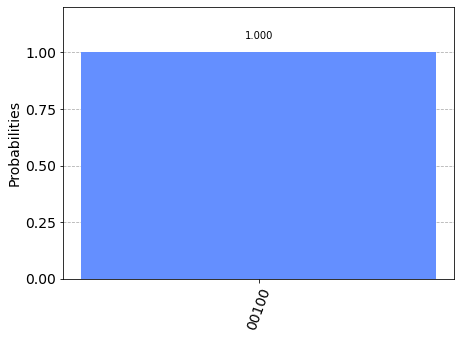

[(0.7071067811865476+0.7071067811865475j)]


None

In [73]:
# phase operator as a matrix
T = ([[1,0],[0,exp(complex(0,pi/4))]])
e,v = np.linalg.eig(T)
print("Eigen values for given matrix are : ",e)
#operator to control gate, call transpile convertor qc
T_Gate = qcc(operator = T)
# calling qpe for T_Gate
qpee = my_qpe(w_qubits=5,s_qubits=1,gate = T_Gate, initialize = 'x')
#display(qpee.draw()) ; # To check if it is correct 
from qiskit import execute
simulator = Aer.get_backend('qasm_simulator')
result = execute(qpee, backend = simulator, shots = 4000).result()
display(plot_histogram(result.get_counts(qpee)))
count = result.get_counts(qpee)
plot_to_eigenval2(count, 5)


 $$ T = \begin{bmatrix}
1 & 0\\
0 & e^{\frac{i\pi}{4}}\\
\end{bmatrix}
$$ $\implies$ eigen values = (1, $e^{\frac{i\pi}{4}}$) and eigen vectors = $\begin{bmatrix}
1 \\
0 \\
\end{bmatrix}$, $\begin{bmatrix}
 0\\
1\\
\end{bmatrix}$ 

$$
\implies  \begin{bmatrix}
1 & 0\\
0 & e^{\frac{i\pi}{4}}\\
\end{bmatrix}\begin{bmatrix}
 0\\
1\\
\end{bmatrix} = e^{\frac{i\pi}{4}}\begin{bmatrix}
 0\\
1\\
\end{bmatrix} \\ $$


Therefore eigen value we expect is $ e^{\frac{i\pi}{4}} = 0.707106781+0.707106781j $ which is also the observed.

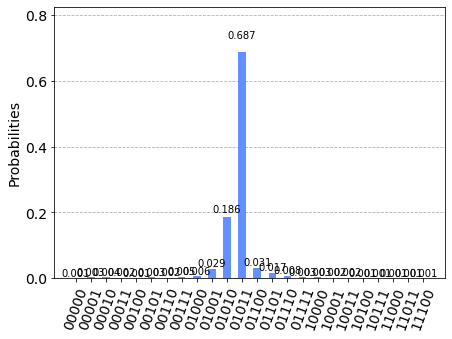

[(-0.7071067811865475+0.7071067811865476j), (-0.555570233019602+0.8314696123025455j), (-0.1950903220161282+0.9807852804032304j), (-0.3826834323650897+0.9238795325112867j), (-0.8314696123025453+0.5555702330196022j)]


None

In [9]:
#Phase as a circuit
def qc2(p):
    qc2 = QuantumCircuit(1)
    qc2.p(2*pi/3,0)
    return qc2
p_gate = qc2(1).to_gate().control(1)

qppe = my_qpe(w_qubits = 5, s_qubits=1, gate = p_gate, initialize = 'x')
# we dont need to call simulator and import again
result = execute(qppe, backend = simulator, shots = 1000).result()
count = result.get_counts(qppe)
display(plot_histogram(result.get_counts(qppe)))
plot_to_eigenval2(count, 5)

Similarly, for $\theta = \frac{2\pi}{3}$, eigen values are (1, -0.5+0.866025403j), and one of observed eigen value is $e^{i2\pi\frac{11}{2^5}}$ = {-0.555570233+0.831469612j}

## Q) Why do we see single peaks for $\frac{\pi}{4}$ and not for $\frac{\pi}{12}$? 
## Ans) The reason being that, for $\frac{\pi}{4}$ case we can easily break 1/8 (the $\theta$) as a decimal/$2^n$, but not for 1/24. Infact we can do this for any $\theta$ that can be divided into a single valued decimal/$2^n$. 

## Testing with 2 qubit CNOT gate

Eigen values for given matrix are :  [0.92387953+0.38268343j 0.92387953-0.38268343j 0.92387953+0.38268343j
 0.92387953+0.38268343j]


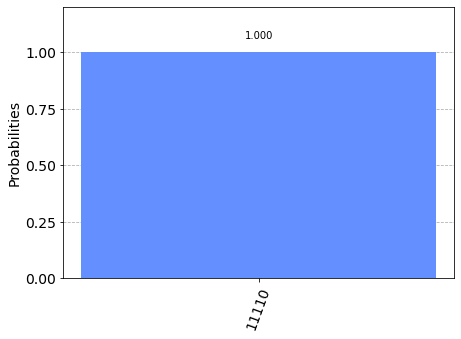

[(0.9238795325112867-0.3826834323650898j)]


None

In [73]:
#exp(i(CNOT)t) where t = pi/8 using obtained using wolfram alpha
import scipy
op2 = ([[complex(0,pi/8),0,0,0],[0,complex(0,pi/8),0,0],[0,0,0,complex(0,pi/8)],[0,0,complex(0,pi/8),0]])
U2_op = scipy.linalg.expm(op2) # just to check that same matrix is produced by scipy exponentiation
#display(U2_op)
e,v = np.linalg.eig(U2_op)
print("Eigen values for given matrix are : ",e)
U = qc(U2_op,[0,1]).to_gate().control(1)

qpp = my_qpe(w_qubits = 5, s_qubits=2, gate = U, initialize = 'cx') #cx initializes to 3rd eigen vector
# we dont need to call simulator and import again
result = execute(qpp, backend = simulator, shots = 1000).result()
display(plot_histogram(result.get_counts(qpp)))
count = result.get_counts(qpp)
plot_to_eigenval2(count, 5)


$$e^{it(CNOT)} = \begin{bmatrix}
e^{\frac{i\pi}{8}} & 0 & 0 & 0\\
0 & e^{\frac{i\pi}{8}} & 0 & 0\\
0 & 0 & cos(\frac{\pi}{8}) & i.sin(\frac{\pi}{8})\\
0 & 0 & i.sin(\frac{\pi}{8}) & cos(\frac{\pi}{8})\\
\end{bmatrix}$$  for t = $\frac{\pi}{8}$
has eigen values = {(0.92387953+0.38268343j)*3, (0.92387953-0.38268343j)}  and eigen vectors = $\begin{bmatrix}
0 \\0\\1\\0\end{bmatrix}
$, $\begin{bmatrix}
0 \\0\\0\\1\end{bmatrix}
$, $\begin{bmatrix}
1/\sqrt(2) \\-1/\sqrt(2)\\0\\0\end{bmatrix}
$, $\begin{bmatrix}
1/\sqrt(2)\\1/\sqrt(2)\\0\\0\end{bmatrix}
$  

$$\implies \begin{bmatrix}
e^{\frac{i\pi}{8}} & 0 & 0 & 0\\
0 & e^{\frac{i\pi}{8}} & 0 & 0\\
0 & 0 & cos(\frac{\pi}{8}) & i.sin(\frac{\pi}{8})\\
0 & 0 & i.sin(\frac{\pi}{8}) & cos(\frac{\pi}{8})\\
\end{bmatrix}\begin{bmatrix}
1/\sqrt(2) \\-1/\sqrt(2)\\0\\0\end{bmatrix} = e^{\frac{i\pi}{8}}\begin{bmatrix}
1/\sqrt(2) \\-1/\sqrt(2)\\0\\0\end{bmatrix}
$$
Therefore the expected eigen value is $ e^{\frac{i\pi}{8}} = (0.9238795325112867+0.3826834323650898j) $

## Testing of Pairing part of pairing Hamiltonian for 2 qubits and for different values of t

Eigen value by algebra : [0.98078528+0.19509032j 0.98078528-0.19509032j 1.        +0.j
 1.        +0.j        ]


None

[(0.9807852804032304-0.19509032201612825j)]


None

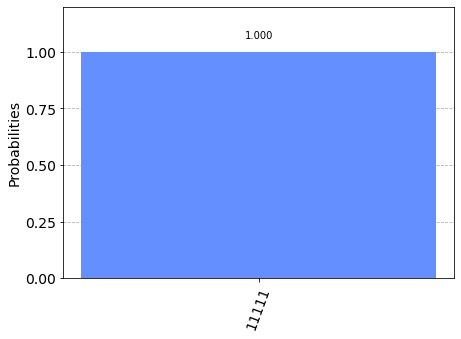

In [19]:
for i in range(1,2):
    H = ([[1,0,0,0],[0,cos(t[i]),complex(0,sin(t[i])),0],[0,complex(0,sin(t[i])), cos(t[i]), 0],[0, 0, 0, 1]])
    e,v = np.linalg.eig(H)
    display(print("Eigen value by algebra :",e))
    #display(qch().draw())#just to see 
    Ut = qc(H,[0,1]).to_gate().control(1)
    qpevw = my_qpe(5,2,Ut,'H')
    result = execute(qpevw, backend = simulator, shots = 1000).result()
    count = result.get_counts(qpevw)
    plot_to_eigenval(count,5)
    display(plot_histogram(result.get_counts(qpevw)))

## Eigen value via linear algebra and its comparision by above result
Put d = 0 and g = 1

H = $\frac{-1}{2}$($X_1X_0 + Y_1Y_0$ ) 
= $\begin{bmatrix} 
0 & 0 & 0 & 0 \\ 
0 & 0 & -1 & 0 \\ 
0 & -1 & 0 & 0 \\ 
0 & 0 & 0 & 0 \\ 
\end{bmatrix}$
$\implies$ Evolution matrix is given by : U = $\begin{bmatrix} 
1 & 0 & 0 & 0 \\ 
0 & cos(t) & i.sin(t) & 0 \\ 
0 & i.sin(t) & cos(t) & 0 \\ 
0 & 0 & 0 & 1 \\ 
\end{bmatrix}$  
$\implies$ The eigen values are {$e^{it}$,$e^{-it}$,1,1} and eigen vectors are $\begin{bmatrix}
0 \\1/\sqrt(2)\\1/\sqrt(2)\\0\end{bmatrix}
$, $\begin{bmatrix}
0 \\-1/\sqrt(2)\\1/\sqrt(2)\\0\end{bmatrix}
$, $\begin{bmatrix}
1 \\0\\0\\0\end{bmatrix}
$, $\begin{bmatrix}
0\\0\\0\\1\end{bmatrix}$, We chose the 2nd eigen vector.

$\implies$  $\begin{bmatrix} 
1 & 0 & 0 & 0 \\ 
0 & cos(t) & i.sin(t) & 0 \\ 
0 & i.sin(t) & cos(t) & 0 \\ 
0 & 0 & 0 & 1 \\ 
\end{bmatrix}$$\begin{bmatrix}
0\\-1/\sqrt(2)\\1/\sqrt(2)\\0\end{bmatrix}$ =  $e^{-it}$$\begin{bmatrix}
0\\-1/\sqrt(2)\\1/\sqrt(2)\\0\end{bmatrix}$. 

## Applying QPE to Pairing Hamiltonian for d=0 and g=1, number of particle 

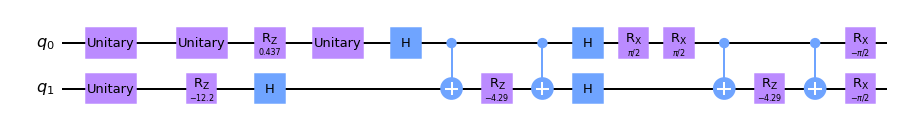

In [80]:
t = 1
unit1 = ([[np.exp(-5.906709j*t), 0],[0, np.exp(-5.906709j*t)]])
unit2 = ([[np.exp(-0.218291j*t), 0],[0, np.exp(-0.218291j*t)]])
unit3 = ([[np.exp(6.125j*t), 0],[0, np.exp(6.125j*t)]])
cir = QuantumCircuit(2)
cir.unitary(unit1,0)
cir.unitary(unit1,0)
cir.rz(0.218291*2*t,0)
cir.unitary(unit2*t,1)
cir.unitary(unit3*t,0)
cir.rz(-6.125*t*2,1)
#implementing exp(cXX)
cir.h(0)
cir.h(1)
cir.cx(0,1)
cir.rz(-2.143304*t*2,1)
cir.cx(0,1)
cir.h(0)
cir.h(1)
#implementing exp(dYY)
cir.rx(np.pi/2,0)
cir.rx(np.pi/2,0)
cir.cx(0,1)
cir.rz(-2.143304*t*2,1)
cir.cx(0,1)
cir.rx(-np.pi/2,0)
cir.rx(-np.pi/2,1)
display(cir.draw())
ga = cir.to_gate().control(1)

In [9]:
from qiskit import execute
#ga = qcc(evol)
qpe_12_par = my_qpe(7,2,gate = ga,initialize = 'h')

simulator = Aer.get_backend('qasm_simulator')
result = execute(qpe_12_par, backend = simulator, shots = 1000).result()
count = result.get_counts(qpe_12_par)
#plot_to_eigenval(count,7)
display(plot_histogram(result.get_counts(qpe_12_par)))
display(print(count))

Traceback (most recent call last):
  File "/tmp/ipykernel_1284/946093521.py", line 3, in <module>
    qpe_12_par = my_qpe(7,2,gate = ga,initialize = 'h')
NameError: name 'ga' is not defined

Use %tb to get the full traceback.


In [84]:
plot_to_eigenval(count,7,3)

[-1.6198837120072371, 0.4908738521234052, 0.44178646691106466]


None

3 qubit case

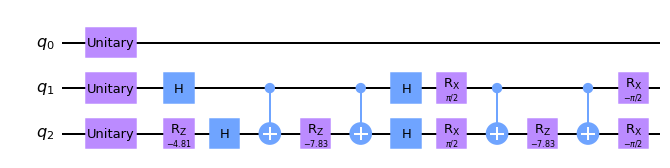

In [47]:
unit4 = Operator([[np.exp(-9.625j*t),0],[0,np.exp(-9.625j*t)]])
qci = QuantumCircuit(3)
qci.compose(cir,[0,1])
qci.unitary(unit4,0)
qci.unitary(unit4,1)
qci.unitary(unit4,2)
qci.rz(-9.625/2*t,2)
#implementing exp(cXX)
qci.h(1)
qci.h(2)
qci.cx(1,2)
qci.rz(-3.913119*t*2,2)
qci.cx(1,2)
qci.h(1)
qci.h(2)
#implementing exp(dYY)
qci.rx(np.pi/2,1)
qci.rx(np.pi/2,2)
qci.cx(1,2)
qci.rz(-3.913119*t*2,2)
qci.cx(1,2)
qci.rx(-np.pi/2,1)
qci.rx(-np.pi/2,2)
qci.draw()

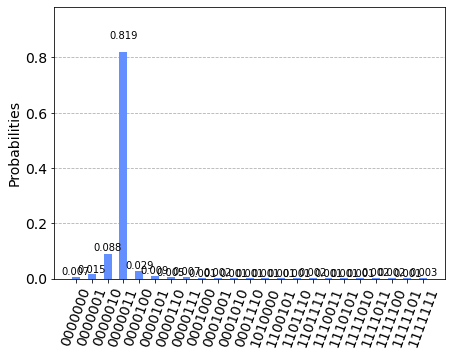

{'1100101': 1, '1111011': 2, '0000111': 7, '0000000': 7, '0000011': 819, '0000100': 29, '1010000': 1, '0000110': 5, '1111111': 3, '0001000': 1, '1111100': 2, '1111010': 1, '0000001': 15, '0000010': 88, '1110011': 1, '1110101': 1, '1101111': 2, '0001010': 1, '1101110': 1, '0000101': 9, '0001001': 2, '0001110': 1, '1111101': 1}


None

In [60]:
gte = qci.to_gate().control(1)
qpe_12_par = my_qpe(7,3,gate = gte, initialize = 'x')

simulator = Aer.get_backend('qasm_simulator')
result = execute(qpe_12_par, backend = simulator, shots = 1000).result()
count = result.get_counts(qpe_12_par)
#plot_to_eigenval(count,7)
display(plot_histogram(result.get_counts(qpe_12_par)))
display(print(count))

In [61]:
plot_to_eigenval(count,7,1)


[0.14726215563702155]


None

In [ ]:
t = 1/50
w = 3.8
qc = QuantumCircuit(1)
qc.rz(2*w*t,0)
gate = qc.to_gate().control(1)
initial_state = [1,0]
qpe_12_par = my_qpe(5,1,gate = gate,n=5, initialize = initial_state)

simulator = Aer.get_backend('qasm_simulator')
result = execute(qpe_12_par, backend = simulator, shots = 3000).result()
count = result.get_counts(qpe_12_par)
#plot_to_eigenval(count,7)
display(plot_histogram(result.get_counts(qpe_12_par)))
display(print(count))

In [20]:
plot_to_eigenval(count,7,1)


[26.50718801466388]


None

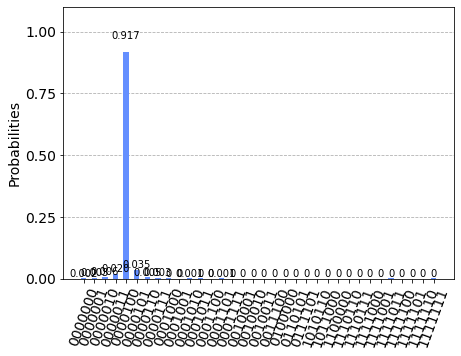

{'1011000': 1, '1111101': 1, '0001100': 1, '0010010': 1, '0111101': 1, '0100000': 1, '1110111': 1, '0011100': 1, '1111111': 3, '1111011': 3, '0001111': 1, '1110110': 1, '0110101': 1, '0000110': 20, '1010110': 1, '1111000': 2, '0001000': 3, '1111100': 2, '0001001': 2, '0000101': 138, '1100000': 1, '0000100': 3668, '0000011': 79, '1111110': 1, '0000111': 11, '0000010': 24, '0001010': 4, '0010001': 1, '0000001': 10, '0001101': 4, '0000000': 7, '0001011': 3, '0010011': 1, '1111001': 1}


None

In [12]:
w_1 = 0.33
w_2 = 3.24
w_3 = 1.17
qc = QuantumCircuit(2)
qc.rz(2*w_1*t,0)
qc.rz(2*w_2*t,1)
qc.cx(0,1)
qc.rz(2*w_3*t,1)
qc.cx(0,1) 
gate = qc.to_gate().control(1)
initial_state = [0,0,1,0]
qpe_12_par = my_qpe(7,2,gate = gate, initialize = initial_state)
result = execute(qpe_12_par, backend = simulator, shots = 4000).result()
count = result.get_counts(qpe_12_par)
#plot_to_eigenval(count,7)
display(plot_histogram(result.get_counts(qpe_12_par)))
display(print(count))

In [13]:
plot_to_eigenval(count,7,1)

[19.634954084936208]


None

#### As expected we are  able to sample some of the eigen values for different values of t. Although we ran only 1 instance of t since it takes very long time to sample 4-5 time intervals at once. 

## Difference in our results vs the paper :
- The initial state of their results was a random state and so do ours so, they may not match.
- The best we can expected is to match some of the eigen values by sampling many time intervals and different random initial state.

## Bug in the definition of plot_to_eigenval:
The code samples all data points that have 10+ occurance in a simulation, which is mostly greater than the actual eigen value that the qpe projects, therefore we sample some extra unrequired eigen values. Need to fix that.

## Else can be verified correctly



# Conclusions:

#### The codes defined for each operation works as expected. 
#### An arbitary initial state is also able to produce expected phase.
#### But along with expected result some different small peaks are also observed.
#### The number of significant high peaks correspond to number of eigen values of the evolution operator.
#### Different values t can be set to produce different parts of the eigen value spectrum.
#### There is a maximum limit to t upto which QPE can produce approximately correct results.
#### Best results are obtained if the intial state is set to eigen state of evolution operator.
